# Curvelet Transform Tutorial

Curvelets are a mathematical tool specifically designed for detecting sharp edges and sudden changes in data. Most of us are familiar with Fourier and Wavelet transforms. While Fourier analysis uses sine and cosine functions to study signals, Wavelets (or the Discrete Cosine Transform, DCT) employ a broader set of functions to analyze data. However, Wavelets often struggle with curved edges, performing well mainly on horizontal and vertical structures. In 2D image processing, curved edges can cause blockiness when using these traditional tools.

As part of our project MiMiC, we aim to apply the Curvelet transform because it can effectively handle edges at any angle, making it well-suited for detecting cold fronts from brightness, temperature, and density maps. Additionally, Curvelets are optimal for wave-like patterns, conserve total energy, and maintain unitarity. Although deep learning has surpassed classical algorithms in many areas, there are scenarios like the minihalos in our project where limited training data is available. In these cases, the Curvelet transform remains as the most powerful and the most relevant tool.

## Starting from the Fourier

Before we can apply curvelets, we need to understand the Fourier Transform, because curvelets are built on its ideas. Simply put, the Fourier Transform and more specifically, the 2D Fast Fourier Transform (FFT) tells us how an image changes in different directions. To start, let’s create a simple example that changes only in one direction but stays constant in others. This will help us understand how the Fourier Transform captures changes in an image and gives us the foundation for understanding curvelets.

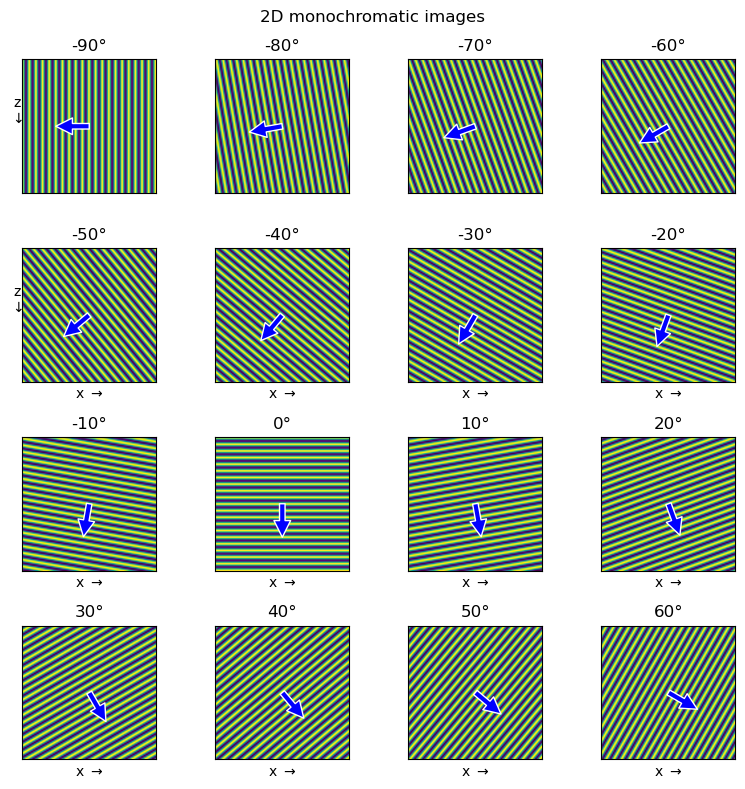

In [1]:
from math import ceil, floor

import matplotlib.pyplot as plt
import numpy as np
from pylops.signalprocessing import FFT2D
from pylops.utils.tapers import taper2d #this library smoothens the images as FFT works best with the edges fade to 0
from scipy.signal import filtfilt #This library helps to preserve images without shifting features

plt.rcParams.update({"image.interpolation": "blackman"})

def sample_2d(
    theta_deg: float = 0, #angle with the horizontal axis
    nx: int = 101, #number of pixels in x axis
    ny: int = 101, #number of pixels in z axis
    freq: float = 10, #number of stripes
    taper: bool = False,
):
    x = np.linspace(-1, 1, nx) #creates x axis
    y = np.linspace(-1, 1, ny) #creates y axis
    dx, dy = x[1] - x[0], y[1] - y[0] 
    xm, ym = np.meshgrid(x, y, indexing="ij")
    theta = np.deg2rad(theta_deg) #angle conversion from degrees to radians
    vec = np.array([np.sin(theta), np.cos(theta)]) #defining direction of the wave
    img = np.cos(2 * np.pi * freq * (vec[0] * xm + vec[1] * ym)) #creates 2D cosine wave along direction

    if taper:
        img *= taper2d(*img.shape, [nx // 5 + 1, ny // 5 + 1])
    return img, x, y, vec

nthetas = 16 #number of images
frequency = 10 #number of stripes of frequencies 
thetas = np.linspace(-90, 60, nthetas)

cols = ceil(np.sqrt(nthetas))
rows = ceil(nthetas / cols)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows)) #define visualizetion
for iax, (theta, ax) in enumerate(zip(thetas, axes.ravel())):
    img, x, y, vec = sample_2d(theta, freq=frequency)
    ax.imshow(
        img.T, vmin=-1, vmax=1, cmap="viridis", extent=[x[0], x[-1], y[-1], y[0]]
    )
    ax.set_title(f"{theta:.0f}°")
    ax.annotate(
        f"",
        xy=(vec[0] * 0.5, vec[1] * 0.5),
        xytext=(0, 0),
        arrowprops=dict(edgecolor="w", facecolor="b"), #set the marker
    )
    if iax == 0 or iax == cols:
        ax.set_ylabel("z\n" + r"$\downarrow$", rotation=0)
    if iax >= cols:
        ax.set_xlabel(r"x $\rightarrow$")
for ax in axes.ravel():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
fig.suptitle("2D monochromatic images")
fig.tight_layout()

Now, we will me making an image in 45 degree direction and we will try to interpreting the results after applying 2D FFT into it.

Text(0.5, 0.98, '2D FFT of a Signal')

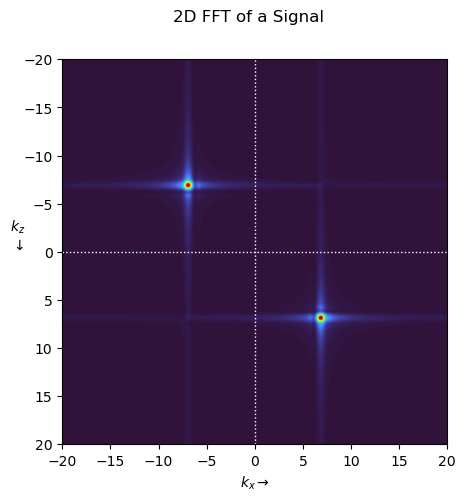

In [2]:
img, x, y, vec = sample_2d(45)
dx, dy = x[1] - x[0], y[1] - y[0]

F2D = FFT2D(
    img.shape,
    sampling=(dx, dy),
    ifftshift_before=True,
    fftshift_after=True,
    norm="ortho",
    real=False,
)
kx = F2D.f1  # Unit is 1 / (unit of dx)
ky = F2D.f2  # Unit is 1 / (unit of dy)

img_k = F2D @ img
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(
    np.abs(img_k).T,
    vmin=0,
    cmap="turbo",
    extent=[kx[0], kx[-1], ky[-1], ky[0]],
)
ax.set(
    xlim=[-2 * frequency, 2 * frequency], ylim=[2 * frequency, -2 * frequency],
    xlabel=r"$k_x \rightarrow$"
)
ax.set_ylabel(r"$k_z$" + "\n" + r"$\downarrow$", rotation=0)
ax.axhline(0, ls=":", color="w", lw=1)
ax.axvline(0, ls=":", color="w", lw=1)
fig.suptitle("2D FFT of a Signal")

In Fourier space, the image shows two distinct peaks. This happens because we are working with real-valued images, and a cosine wave can be represented as the sum of two complex exponentials with positive and negative frequencies. As a result, the 2D Fourier transform of a real image is symmetric about the origin. This symmetry means that the information in the upper-right quadrant is mirrored in the lower-left quadrant, and likewise the upper-left and lower-right quadrants contain identical information. Therefore, we can safely ignore one half of Fourier space and analyze either the positive or the negative frequencies alone. However, this symmetry property does not hold for complex-valued images, where positive and negative frequencies carry independent information. Let's find the position of the brightest positions now.

In [3]:
def ndargmax(ary):
    return np.unravel_index(ary.argmax(), ary.shape)


def find_kmax(img_k, kx, ky, unit=False):
    kxmax, kzmax = ndargmax(np.abs(img_k[:, ky >= 0]))
    kvec = np.array([kx[kxmax], ky[ky >= 0][kzmax]])
    if unit:
        kvec /= np.linalg.norm(kvec)
    return kvec
kvec = find_kmax(img_k, kx, ky)
kvec / np.linalg.norm(kvec)

array([0.70710678, 0.70710678])

In [4]:
vec

array([0.70710678, 0.70710678])

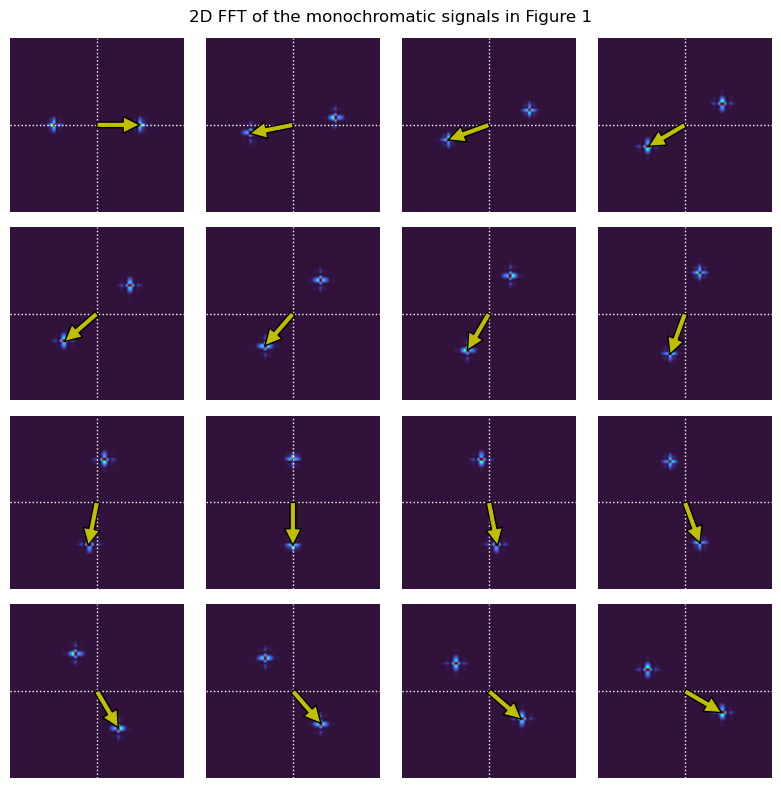

In [5]:
nthetas = 16 #number of images
frequency = 10 #number of stripes of frequencies 
thetas = np.linspace(-90, 60, nthetas)

cols = ceil(np.sqrt(nthetas))
rows = ceil(nthetas / cols)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
for theta, ax in zip(thetas, axes.ravel()):
    img, x, y, _ = sample_2d(theta, freq=frequency, taper=True)
    img_k = F2D @ img #Applying 2D FFT
    kvec_max = find_kmax(img_k, kx, ky) #Find brightest Fourier peak

    ax.imshow(
        np.abs(img_k).T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], ky[-1], ky[0]],
    )
    ax.set(
        xlim=[-2 * frequency, 2 * frequency],
        ylim=[2 * frequency, -2 * frequency],
    )
    ax.axhline(0, ls=":", color="w", lw=1)
    ax.axvline(0, ls=":", color="w", lw=1)
    ax.annotate(
        "",
        xy=(kvec_max[0], kvec_max[1]),
        xytext=(0.0, 0.0),
        arrowprops=dict(edgecolor="k", facecolor="y"),
    )
for ax in axes.ravel():
    ax.axis("off")
fig.suptitle("2D FFT of the monochromatic signals in Figure 1")
fig.tight_layout()

Now let's look at the directions if those remained constants before and after applying FFT

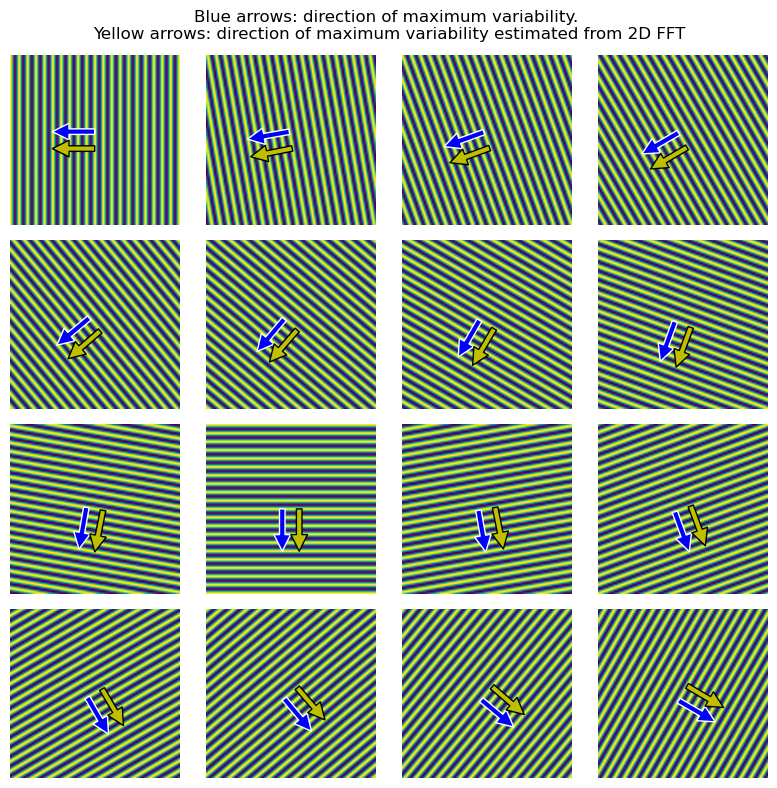

In [6]:
nthetas = 16 #number of images
frequency = 10 #number of stripes of frequencies 
thetas = np.linspace(-90, 60, nthetas)

cols = ceil(np.sqrt(nthetas))
rows = ceil(nthetas / cols)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
for theta, ax in zip(thetas, axes.ravel()):
    img, x, y, vec = sample_2d(theta, freq=frequency)

    img_k = F2D @ img
    kvec_max = find_kmax(img_k, kx, ky, unit=True)

    im = ax.imshow(
        img.T, vmin=-1, vmax=1, cmap="viridis", extent=[x[0], x[-1], y[-1], y[0]]
    )
    norm = 0.5
    offset = 0.1 * np.array([vec[1], -vec[0]])
    ax.annotate(
        "",
        xy=(-offset[0] + vec[0] * norm, -offset[1] + vec[1] * norm),
        xytext=-offset,
        arrowprops=dict(edgecolor="w", facecolor="b"),
    )
    ax.annotate(
        "",
        xy=(offset[0] + kvec_max[0] * norm, offset[1] + kvec_max[1] * norm),
        xytext=offset,
        arrowprops=dict(edgecolor="k", facecolor="y"),
    )
for ax in axes.ravel():
    ax.axis("off")
fig.suptitle("Blue arrows: direction of maximum variability. \nYellow arrows: direction of maximum variability estimated from 2D FFT")
fig.tight_layout()

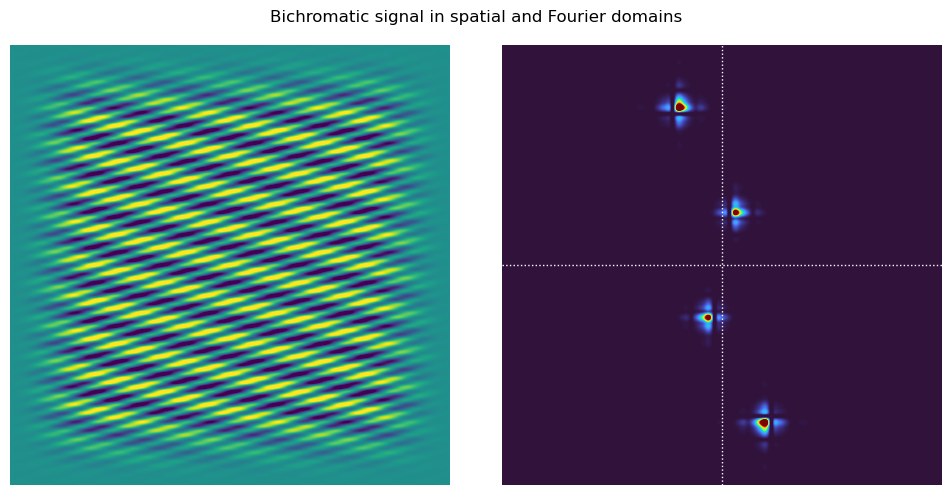

In [7]:
img_lo, *_ = sample_2d(
    -15,
    freq=0.25 * np.abs(ky).max(), #make wider stripes because of low frequency
    taper=True,  # taper prevents Gibb's effect
)
img_hi, *_ = sample_2d(
    15, freq=0.75 * np.abs(ky).max(), taper=True #make sharp stripes because of high frequency
)
img = 0.4 * img_lo + 0.6 * img_hi
img_k = F2D @ img

vmax = 0.75 * np.abs(img).max()
vmax_k = 0.5 * np.abs(img_k).max()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(
    img.T,
    vmin=-vmax,
    vmax=vmax,
    cmap="viridis",
    extent=[x[0], x[-1], y[-1], y[0]],
)
axes[1].imshow(
    np.abs(img_k).T,
    vmin=0,
    vmax=vmax_k,
    cmap="turbo",
    extent=[kx[0], kx[-1], ky[-1], ky[0]],
)
axes[1].axhline(0, ls=":", color="w", lw=1)
axes[1].axvline(0, ls=":", color="w", lw=1)
for ax in axes.ravel():
    ax.axis("off")
fig.suptitle("Bichromatic signal in spatial and Fourier domains")
fig.tight_layout()

### Building the Curvelet Transform

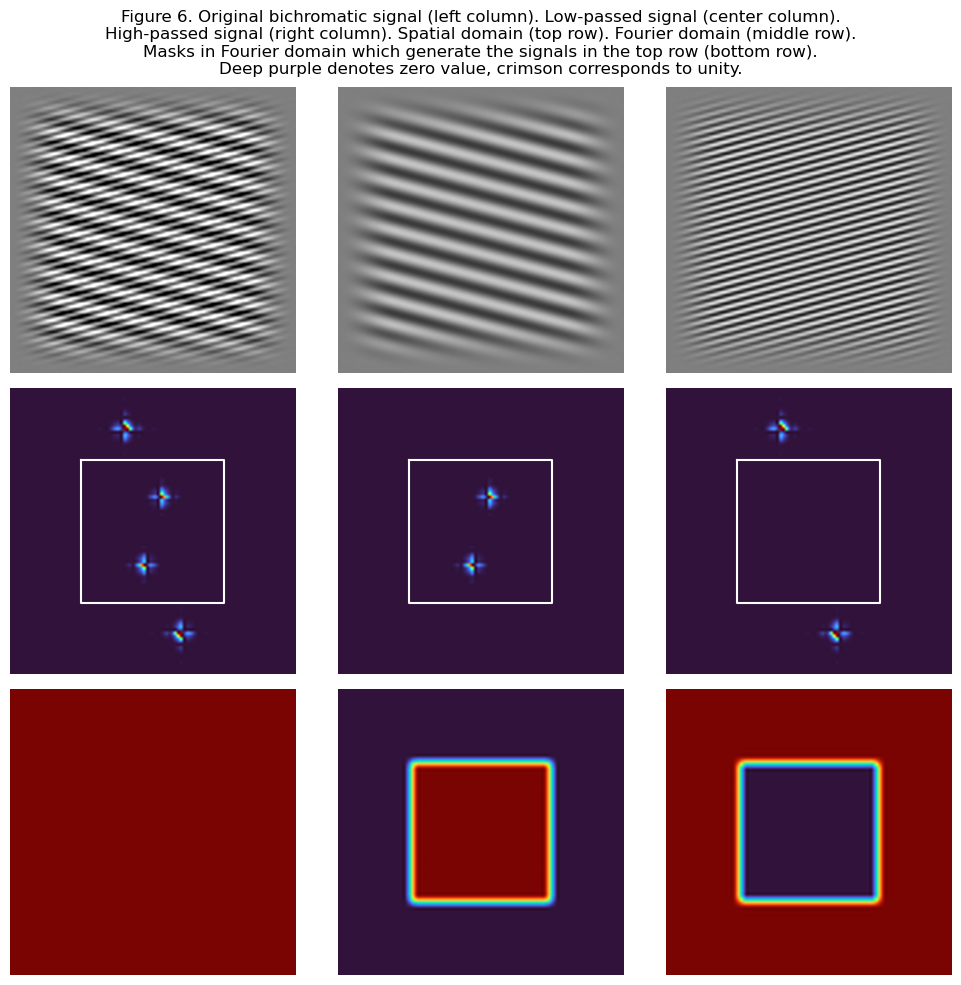

In [10]:
def build_lowpass(kx, ky, nsmooth=None):
    if nsmooth is None:
        nsmooth = 0.01 * min(len(kx), len(ky))
        nsmooth = 2 * max(1, floor(nsmooth / 2)) + 1
    mask = np.zeros((len(kx), len(ky)))
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    kxnyq = np.abs(kx).max()
    kynyq = np.abs(ky).max()
    inside_scale = (np.abs(KX) < 0.5 * kxnyq) & (np.abs(KY) < 0.5 * kynyq)
    mask[inside_scale] = 1.0
    s = np.ones((nsmooth,)) / nsmooth
    mask = filtfilt(s, 1, mask, axis=0)
    mask = filtfilt(s, 1, mask, axis=1)
    return mask


lowpass = build_lowpass(kx, ky)
highpass = 1.0 - lowpass
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, _mask in enumerate(
    [lowpass + highpass, lowpass, highpass],
):
    _img_k = _mask * img_k
    _img = (F2D @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        extent=[x[0], x[-1], y[-1], y[0]],
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        extent=[kx[0], kx[-1], ky[-1], ky[0]],
    )
    kxnyq = 0.5 * np.abs(kx).max()
    kynyq = 0.5 * np.abs(ky).max()
    axes[1, i].plot(
        [-kxnyq, kxnyq, kxnyq, -kxnyq, -kxnyq],
        [-kynyq, -kynyq, kynyq, kynyq, -kynyq],
        color="w",
    )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], ky[-1], ky[0]],
    )
for ax in axes.ravel():
    ax.axis("off")
fig.suptitle("Figure 6. Original bichromatic signal (left column). Low-passed signal (center column).\nHigh-passed signal (right column). Spatial domain (top row). Fourier domain (middle row).\nMasks in Fourier domain which generate the signals in the top row (bottom row).\nDeep purple denotes zero value, crimson corresponds to unity.")
fig.tight_layout()

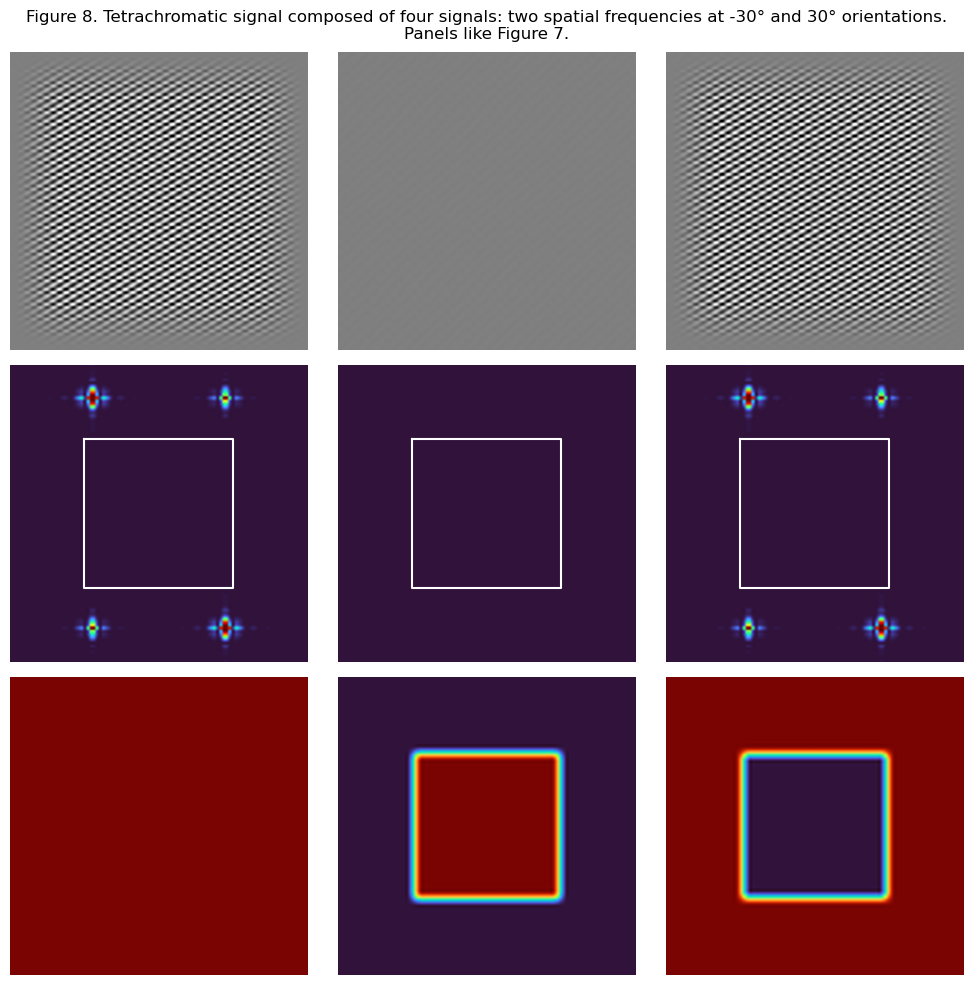

In [14]:
img_lo, *_ = sample_2d(
    -30, freq=0.9 * np.abs(ky).max(), taper=True
)
img_hi, *_ = sample_2d(
    30, freq=0.9 * np.abs(ky).max(), taper=True
)
img = 0.3 * img_lo + 0.7 * img_hi
img_k = F2D @ img

vmax = 0.75 * np.abs(img).max()
vmax_k = 0.2 * np.abs(img_k).max()
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, _mask in enumerate(
    [lowpass + highpass, lowpass, highpass],
):
    _img_k = _mask * img_k
    _img = (F2D @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        extent=[x[0], x[-1], y[-1], y[0]],
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        extent=[kx[0], kx[-1], ky[-1], ky[0]],
    )
    kxnyq = 0.5 * np.abs(kx).max()
    kynyq = 0.5 * np.abs(ky).max()
    axes[1, i].plot(
        [-kxnyq, kxnyq, kxnyq, -kxnyq, -kxnyq],
        [-kynyq, -kynyq, kynyq, kynyq, -kynyq],
        color="w",
    )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], ky[-1], ky[0]],
    )
for ax in axes.ravel():
    ax.axis("off")
fig.suptitle("Figure 8. Tetrachromatic signal composed of four signals: two spatial frequencies at -30° and 30° orientations.\nPanels like Figure 7.")
fig.tight_layout()

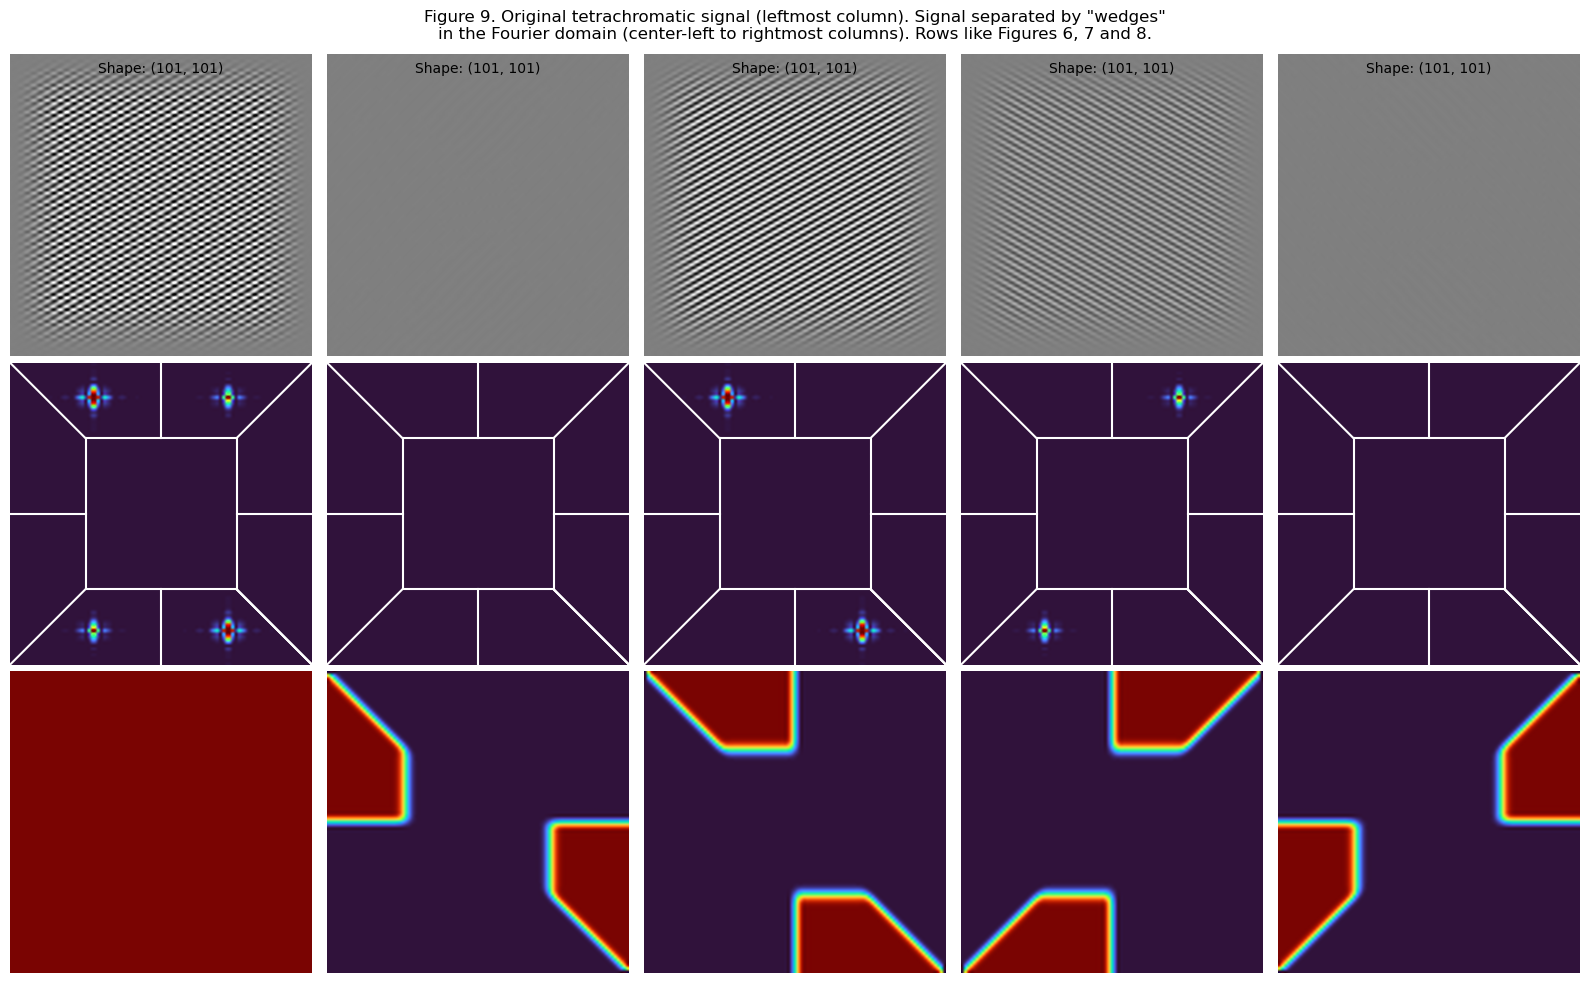

In [17]:
def build_8wedges_sym(kx, ky, wedge=0, nsmooth=None):
    lopass = build_lowpass(kx, ky, nsmooth=nsmooth)
    if nsmooth is None:
        nsmooth = 0.01 * min(len(kx), len(ky))
        nsmooth = 2 * max(1, floor(nsmooth / 2)) + 1

    mask = np.zeros_like(lopass)
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    kxnyq = np.abs(kx).max()
    kynyq = np.abs(ky).max()

    s = 1 if wedge == 0 or wedge == 1 else -1
    K1 = KX if wedge == 0 or wedge == 2 else KY
    K2 = KY if wedge == 0 or wedge == 2 else KX
    inside_wedge = (s * (np.abs(K1) - np.abs(K2)) > 0) & (s * KX * KY > 0)
    mask[inside_wedge] = 1
    mask[inside_wedge] -= lopass[inside_wedge]
    s = np.ones((nsmooth,)) / nsmooth
    mask = filtfilt(s, 1, mask, axis=0)
    mask = filtfilt(s, 1, mask, axis=1)
    return mask


wedges = [build_8wedges_sym(kx, ky, wedge=wedge) for wedge in range(4)]
fig, axes = plt.subplots(3, 5, figsize=(16, 10))
for i, _mask in enumerate(
    [lowpass + highpass, *wedges],
):
    _img_k = img_k * _mask
    _img = (F2D.H @ _img_k).real
    axes[0, i].imshow(
        _img.T,
        vmin=-vmax,
        vmax=vmax,
        cmap="gray",
        extent=[x[0], x[-1], y[-1], y[0]],
    )
    axes[0, i].text(
        0.5,
        0.95,
        f"Shape: {_img.shape}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[0, i].transAxes,
    )
    axes[1, i].imshow(
        np.abs(_img_k).T,
        vmin=0,
        vmax=vmax_k,
        cmap="turbo",
        extent=[kx[0], kx[-1], ky[-1], ky[0]],
    )
    kxmax = np.abs(kx).max()
    kymax = np.abs(ky).max()
    axes[1, i].plot(
        0.5 * np.array([-kxmax, kxmax, kxmax, -kxmax, -kxmax]),
        0.5 * np.array([-kymax, -kymax, kymax, kymax, -kymax]),
        color="w",
    )
    for s in [1, -1]:
        axes[1, i].plot(
            [s * kxmax, s * 0.5 * kxmax],
            [s * kymax, s * 0.5 * kymax],
            color="w",
        )
        axes[1, i].plot(
            [kxmax, 0.5 * kxmax],
            [s * kymax, s * 0.5 * kymax],
            color="w",
        )
        axes[1, i].plot(
            [-s * kxmax, -s * 0.5 * kxmax],
            [kymax, 0.5 * kymax],
            color="w",
        )
        axes[1, i].plot(
            [0, 0],
            [s * kymax, s * 0.5 * kymax],
            color="w",
        )
        axes[1, i].plot(
            [s * kxmax, s * 0.5 * kxmax],
            [0, 0],
            color="w",
        )
    axes[2, i].imshow(
        _mask.T,
        vmin=0,
        cmap="turbo",
        extent=[kx[0], kx[-1], ky[-1], ky[0]],
    )
for ax in axes.ravel():
    ax.axis("off")
fig.suptitle("Figure 9. Original tetrachromatic signal (leftmost column). Signal separated by \"wedges\"\nin the Fourier domain (center-left to rightmost columns). Rows like Figures 6, 7 and 8.")
fig.tight_layout()

### Fast Discrete Curvelet Transform

In [13]:

from curvelops import FDCT2D
from curvelops.plot import curveshow

C2D = FDCT2D(img.shape, nbscales=2, nbangles_coarse=8, allcurvelets=True)

# `FDCT2D` returns an unstructured unidimensional vector, we will reorganize the
# coefficients by structuring them as a list of lists. These in turn can be
# indexed as C[scale][wedge][zpos, xpos].
# Note that the `FDCT2D` transposes the dimensions of the original image.
# This is a remnant of the original implementation.
img_c = C2D.struct(C2D @ img)

# In our previous example, we considered a "wedge" to be symmetric with respect
# to the origin. The `FDCT2D` does not do this by default. Moreover, it will always
# output each unsymmetrized wedge separately. In this example, `nbangles_coarse = 8`
# really only gives us 4 independent wedges. We will symmetrize them as follows
for iscale in range(len(img_c)):
    if len(img_c[iscale]) == 1:  # Not a curvelet transform
        print(f"Wedges in scale {iscale+1}: {len(img_c[iscale])}")
        continue
    nbangles = len(img_c[iscale])
    for iwedge in range(nbangles // 2):
        img_c[iscale][iwedge] = (
            img_c[iscale][iwedge]  # Wedge
            + img_c[iscale][iwedge + nbangles // 2]  # Symmetric counterpart
        ) / np.sqrt(2)
    img_c[iscale] = img_c[iscale][: nbangles // 2]
    print(f"Wedges in scale {iscale+1}: {len(img_c[iscale])}")

figs_axes = curveshow(
    img_c,
    basesize=3,
    kwargs_imshow=dict(vmin=-1, vmax=1, extent=[x[0], x[-1], z[-1], z[0]]),
)
for c_scale, (fig, axes) in zip(img_c, figs_axes):
    for iwedge, (c_wedge, ax) in enumerate(
        zip(c_scale, np.atleast_1d(axes).ravel())
    ):
        ax.text(
            0.5,
            0.95,
            f"Shape: {c_wedge.shape}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

Wedges in scale 1: 1
Wedges in scale 2: 4


NameError: name 'z' is not defined

[N.B: This Notebook is inspired from the Desmystifying_Curvelets and Single_Interactive_Curvelet notebooks from Pylops/curvelops]